## LLM: Batching

In [1]:
import torch
import matplotlib.pyplot as plt
import time
import logging
import random
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm.autonotebook import tqdm


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
random.seed(42)

if torch.cuda.is_available():
    logger.info("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    logger.info("Using MPS")
    device = torch.device("mps")
else:
    logger.info("Using CPU")
    device = torch.device("cpu")
device

INFO:__main__:Using MPS


device(type='mps')

## Helper functions

In [2]:
def generate_token(ins: dict, model) -> (torch.Tensor, torch.Tensor):
    with torch.no_grad():
        _output = model(**ins)

    _next_token = _output.logits[:, -1, :].argmax(dim=1)
    return _output, _next_token

def chat(model, tokeniser, inputs_t0, no_of_tokens = 100):
    generated_tokens = dict()
    inputs_tx = inputs_t0
    if "position_ids" in inputs_t0:
        position_ids = inputs_t0["position_ids"]
    else:
        position_ids = None
    durations_cached_s = []
    for _ in range(no_of_tokens):
        t0 = time.time()
        output, next_token_ids = generate_token(inputs_tx, model)
        durations_cached_s.append(time.time() - t0)
        
        inputs_tx = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "attention_mask": torch.cat(
                [inputs_tx["attention_mask"], torch.ones((inputs_t0["input_ids"].shape[0], 1))],
                dim=1
            ),
            "past_key_values": output.past_key_values,
        }
        
        if position_ids is not None:
            position_ids = position_ids[:, -1].unsqueeze(-1) + 1
            inputs_tx["position_ids"] = position_ids
            
        
        next_tokens = tokeniser.batch_decode(next_token_ids.reshape((inputs_t0["input_ids"].shape[0], 1)))
        for i, token in enumerate(next_tokens):
            if i not in generated_tokens:
                generated_tokens[i] = []
            generated_tokens[i].append(token)
            
    return ["".join(generated_tokens[i]) for i in generated_tokens.keys()], durations_cached_s

## Setup

In [3]:
gpt_tokeniser = AutoTokenizer.from_pretrained("openai-community/gpt2", )
gpt2 = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

gpt_tokeniser.pad_token = gpt_tokeniser.eos_token
gpt2.config.pad_token_id = gpt2.config.eos_token_id

# pad on the left so we can append new tokens on the right
gpt_tokeniser.padding_side = "left"
gpt_tokeniser.truncation_side = "left"

gpt2

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
prompt = "I woke up to the rain and as I looked outside the window"
inputs_t0 = gpt_tokeniser(prompt, return_tensors="pt")

n = 20
generated_tokens, durations_cached_s = chat(gpt2, gpt_tokeniser, inputs_t0)
logger.info(f"Time taken to generate {n} tokens with KC Caching: {sum(durations_cached_s)} s")
generated_tokens

INFO:__main__:Time taken to generate 20 tokens with KC Caching: 2.151087760925293 s


[' my family and friends, I would like to go to the beach and see my family and friends, I would like to go to the beach and see my family and friends, I would like to go to the beach and see my family and friends, I would like to go to the beach and see my family and friends, I would like to go to the beach and see my family and friends, I would like to go to the beach and see my family and friends, I would like to go']

## Implementing Batching

In [6]:
prompts = [
    "I woke up to the rain and as I looked outside the window",
    "Its sunny outside and I think its a perfect time for",
    "Its raining outside and its a bad time for",
]
# Tokenising the prompts
inputs_t0 = gpt_tokeniser(prompts, padding=True, return_tensors="pt")
# Filling position information
_position_ids = inputs_t0["attention_mask"].long().cumsum(-1) - 1
inputs_t0["position_ids"] = _position_ids.masked_fill_(inputs_t0["attention_mask"] == 0, 1)

inputs_t0

{'input_ids': tensor([[ 1722,  1909,   318,   257,  3502,   290,   314,   561,   588,   284,
           467,  3187,   257],
        [50256, 50256, 20459, 27737,  2354,   290,   314,   892,   663,   257,
          2818,   640,   329],
        [50256, 50256, 50256, 50256, 20459, 43079,  2354,   290,   663,   257,
          2089,   640,   329]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'position_ids': tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        [ 1,  1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 1,  1,  1,  1,  0,  1,  2,  3,  4,  5,  6,  7,  8]])}

In [7]:
generated_tokens, durations_cached_s = chat(gpt2, gpt_tokeniser, inputs_t0, no_of_tokens=10)
logger.info(f"Time taken to generate {n} tokens with KC Caching for a batch size of {len(prompts)}: {sum(durations_cached_s)} s")
for prompt, generated in zip(prompts, generated_tokens):
    generated = generated.replace("\n", "")
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

INFO:__main__:Time taken to generate 20 tokens with KC Caching for a batch size of 3: 0.2838120460510254 s


As today is a Sunday and I would like to go visit a  friend who is a teacher. I am a teacher

Its sunny outside and I think its a perfect time for  a picnic.I'm going to be

Its raining outside and its a bad time for  the sun.The sun is shining in


## Throughput vs Latency

In [8]:
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(16)]
for batch_size in batch_sizes:
    logger.info(f"batch-size: {batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = gpt_tokeniser(
        batch_prompts, padding=True, return_tensors="pt"
    )
    generated_tokens, _ = chat(gpt2, gpt_tokeniser, inputs_t0, no_of_tokens=max_tokens)
    duration_s = time.time() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    logger.info(f"duration: {duration_s}")
    logger.info(f"throughput: {throughput}")
    logger.info(f"avg latency: {avg_latency}")    

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

INFO:__main__:batch-size: 1
INFO:__main__:duration: 0.27997326850891113
INFO:__main__:throughput: 35.717695668798164
INFO:__main__:avg latency: 0.027997326850891114
INFO:__main__:batch-size: 2
INFO:__main__:duration: 0.27405381202697754
INFO:__main__:throughput: 72.97836819737878
INFO:__main__:avg latency: 0.027405381202697754
INFO:__main__:batch-size: 4
INFO:__main__:duration: 0.2744922637939453
INFO:__main__:throughput: 145.7235968953465
INFO:__main__:avg latency: 0.02744922637939453
INFO:__main__:batch-size: 8
INFO:__main__:duration: 0.2608921527862549
INFO:__main__:throughput: 306.6401160235081
INFO:__main__:avg latency: 0.02608921527862549
INFO:__main__:batch-size: 16
INFO:__main__:duration: 0.2519679069519043
INFO:__main__:throughput: 635.0015044993045
INFO:__main__:avg latency: 0.02519679069519043
INFO:__main__:batch-size: 32
INFO:__main__:duration: 0.25730013847351074
INFO:__main__:throughput: 1243.6837457549377
INFO:__main__:avg latency: 0.025730013847351074
INFO:__main__:batc

In [9]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

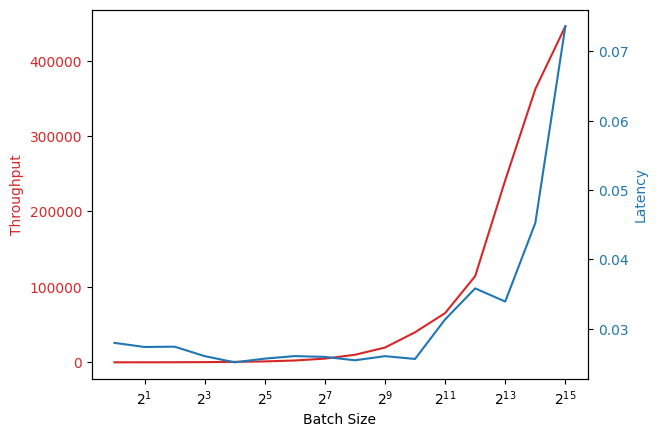

In [10]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)

## Continuous Batching

In [11]:
queue_size = 32
batch_size = 8

request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]

batches = [
    request_queue[i:i + batch_size]
    for i in range(0, len(request_queue), batch_size)
]

#### Batching (Add and Remove prompts when finished for continuous batching)

In [12]:
t0 = time.time()
with tqdm(total=len(batches), desc=f"batch Size={batch_size}") as pbar:
    for i, batch in enumerate(batches):
        # to accommodate all the requests with our 
        # current implementation, we take the max of
        # all the tokens to generate among the requests
        batch_max_tokens = [b[1] for b in batch]
        max_tokens = max(batch_max_tokens)
        pbar.set_postfix({'max_tokens': max_tokens})
        
        batch_prompts = [b[0] for b in batch]
        inputs = gpt_tokeniser(
            batch_prompts, padding=True, return_tensors="pt")
        chat(gpt2, gpt_tokeniser, inputs_t0, no_of_tokens=max_tokens)
        
        pbar.update(1)

duration_s = time.time() - t0
print("duration", duration_s)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


batch Size=8:   0%|          | 0/4 [00:00<?, ?it/s]

duration 11.051194190979004
